In [ ]:
import os.path as ospath
import numpy as np
# pytorch
import torch 
import torch.nn.functional as F # pytorch NN functional module
#pytorch modules
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import pickle

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.5 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 


# Load DataSet  and preprocessing
Here we use the pytorch-Geometric dataset QM9.

In [ ]:
__file__ = 'Project_RGCN-128-testing.ipynb' # an example of a file name to extract the path of the QM dataset
path = ospath.join(ospath.dirname(ospath.realpath(__file__)), '..', 'data', 'QM9')
dataset = QM9(path) # we use in-built pytorch QM9 dataset

Extracting /data/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


# Data Splitting and further processing
Random indices ( but always same) for the right comparsion of differnet models so that Training, Valiation and Test set remain always same

In [ ]:
indices = np.random.RandomState(seed=42).permutation(len(dataset))
# OR
#with open('indices.pkl','rb') as f:
#    indices = pickle.load(f)

In [ ]:
# Split datasets
batchsize = 128
target = 15 # index of atomisation energy (at 0K) in the list of 19 target values 

test_dataset = dataset[indices[0:10000]] # around 10% of complete data
val_dataset = dataset[indices[10000:20000]] # around 10% of complete data
train_dataset = dataset[indices[20000:]] # around 80% of complete data

### Normalisation of target values
Scaling of the target values of training data (atomisation energy) with mean=0 and std =1  
We will use the the the mean (tr_mean) and standard deviation (tr_std) of training data to calculate MAE for validation and test datapoints. 
The intension of doing normalistion of only traing dataset (not for whole dataset) is

1. to take test set as an held-out set   
2. to make our model more robust  
3. to stop information leakage to validation and test set.

In [ ]:
tr_sum = 0
std_sum = 0
for i in range(len(train_dataset)):
     tr_sum += train_dataset[i].y[:,target]
tr_mean = (tr_sum / len(train_dataset)).item()


for i in range(len(train_dataset)):
    std_sum += (train_dataset[i].y[:,target] - tr_mean) ** 2
tr_std = np.sqrt(std_sum / len(train_dataset)).item()

In [ ]:
for i in range(len(train_dataset)):
    train_dataset[i].y[:,target] = (train_dataset[i].y[:,target] - tr_mean) / tr_std

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

### Creation of a new feature edge type
Trasformation of  edge_attr to a single dimension tensor of shape [num(edge_index)] to use in RGCNconv

In [ ]:
#creation of edge_types for RGCNconv
train_edge_types, val_edge_types, test_edge_types = [], [], []

for i in range(len(train_dataset)):
    train_edge_types.append(np.argwhere(train_dataset[i].edge_attr == 1).T [:, 1].tolist())
flat_train_edge_types = [item for sublist in train_edge_types for item in sublist]

for i in range(len(val_dataset)):
    val_edge_types.append(np.argwhere(val_dataset[i].edge_attr == 1).T [:, 1].tolist())
flat_val_edge_types = [item for sublist in val_edge_types for item in sublist]

for i in range(len(test_dataset)):
    test_edge_types.append(np.argwhere(test_dataset[i].edge_attr == 1).T [:, 1].tolist())
flat_test_edge_types = [item for sublist in test_edge_types for item in sublist]

# About made dataset using pytorch-geometric
**x** : node `[num_atoms, num_features]`

**edge_index** : Graph connectivity in COO format
            with shape :`[2, num_edges]` 
    
**edge_attr**: Edge feature matrix with shape
            `[num_edges, num_edge_features]`.  
            
**y**: Graph-level or node-level ground-truth labels
            with arbitrary shape.
            
**pos**: Node position matrix with shape
            `[num_nodes, num_dimensions]`. 
            
The edge_index property holds the information about the graph connectivity, i.e., a tuple of source and destination node indices for each edge.

https://www.youtube.com/watch?v=Vz5bT8Xw6Dc  

https://www.youtube.com/watch?v=Q5T-JdyVCfs

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of type of regression targets: {dataset.num_classes}')
print('======================')
print(f'First graph (CH4 molecule) data structure: \n{dataset[0]}')
print('-------')
print(f'Edge_index in COO format of shape {dataset[0].edge_index.shape}: \n{dataset[0].edge_index}')
print('-------')
print(f'(CH4 molecule) edge_attr of shape {dataset[0].edge_attr.shape} which is [edge_index, num_relations/edge_types] : \n{dataset[0].edge_attr}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of type of regression targets: 19
First graph (CH4 molecule) data structure: 
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
-------
Edge_index in COO format of shape torch.Size([2, 8]): 
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
-------
(CH4 molecule) edge_attr of shape torch.Size([8, 4]) which is [edge_index, num_relations/edge_types] : 
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


# Dataloader implementation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.nn import global_mean_pool

class RGCN(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = RGCNConv(in_channels=dataset.num_features, out_channels=64, num_relations=4)
        self.conv2 = RGCNConv(in_channels=64, out_channels=128, num_relations=4)
        self.conv3 = RGCNConv(in_channels=128, out_channels=256, num_relations=4)
        self.conv4 = RGCNConv(in_channels=256, out_channels=512, num_relations=4)
        self.lin1 = nn.Linear(in_features=512, out_features=256)
        self.lin2 = nn.Linear(in_features=256, out_features=128)
        self.lin3 = nn.Linear(in_features=128, out_features=64)
        self.lin4 = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, x, edge_index, edge_type, batch):
        
        # 1. node embeddings
        x = self.conv1(x, edge_index, edge_type )
        x = F.relu(x)
        
        x = self.conv2(x, edge_index, edge_type)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index, edge_type)
        x = F.relu(x)
        
        x = self.conv4(x, edge_index, edge_type)
        x = F.relu(x)
        
        # 2. Readout layer used for graph level prediction ( 128, 64 )
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        
        # Linear layers
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x.view(-1)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCN(hidden_channels=512).to(device)
print(model)

RGCN(
  (conv1): RGCNConv(11, 64, num_relations=4)
  (conv2): RGCNConv(64, 128, num_relations=4)
  (conv3): RGCNConv(128, 256, num_relations=4)
  (conv4): RGCNConv(256, 512, num_relations=4)
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=0.00001)
criterian = nn.L1Loss()
current_epoch = 0 
loss_epoch_trn_list, MAE_epoch_val_list = [], [] # loss storage lists

for epoch in range(500):
    current_epoch = epoch + 1
    running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
    print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  #__________________#
  # TRAINING
  #__________________#

    model.train()
    for dt in train_loader:
        dt.to(device)
        edge_type_lengths = dt.edge_index.shape[1]
        edge_types = torch.Tensor(flat_train_edge_types[:edge_type_lengths]).int()
    
        # Single forward pass 
        pred = model(dt.x, dt.edge_index, edge_types, dt.batch)
        # Compute the loss
        loss = criterian(pred, dt.y[:,target])
        # backpropogation 
        loss.backward() # Derive gradients
        optimizer.step() # Update parameters based on gradients
        optimizer.zero_grad() # zeroes the gradients
        # statistics
        running_trn_loss += loss.item()
        
    # cummulative training loss after each epoch
    loss_epoch_trn_list.append(running_trn_loss / len(train_dataset))
    print(f"Training MAE loss: {running_trn_loss / len(train_dataset):>7f}")
  
  #_____________#
  # VALIDATION
  #_____________#

    model.eval()
    error = 0
  
    with torch.no_grad():
        for dv in val_loader:
            dv.to(device)
            edge_type_lengths = dv.edge_index.shape[1]
            edge_types = torch.Tensor(flat_val_edge_types[:edge_type_lengths]).int()
            pred = model(dv.x, dv.edge_index, edge_types, dv.batch)
            error += (pred * tr_std + tr_mean - dv.y[:,target]).abs().sum().item()
            
    scheduler.step(error)
    MAE_epoch_val_list.append(error / len(val_dataset))
    print(f'MAE in validation: {error / len(val_dataset):.7f}')
            

    #saving model for minimum validation loss
    if MAE_epoch_val_list[-1] <= min(MAE_epoch_val_list):
        print("model saved\n")
        torch.save(model, './best_128_3RGCN_test.pth')


Epoch 1
-------------------------------
Training MAE loss: 0.002224
MAE in validation: 2.4095218
model saved


Epoch 2
-------------------------------
Training MAE loss: 0.001904
MAE in validation: 2.1594631
model saved


Epoch 3
-------------------------------
Training MAE loss: 0.001835
MAE in validation: 2.1673965

Epoch 4
-------------------------------
Training MAE loss: 0.001784
MAE in validation: 2.0576264
model saved


Epoch 5
-------------------------------
Training MAE loss: 0.001751
MAE in validation: 2.3309028

Epoch 6
-------------------------------
Training MAE loss: 0.001741
MAE in validation: 2.1357761

Epoch 7
-------------------------------
Training MAE loss: 0.001719
MAE in validation: 2.0255660
model saved


Epoch 8
-------------------------------
Training MAE loss: 0.001705
MAE in validation: 2.0509842

Epoch 9
-------------------------------
Training MAE loss: 0.001688
MAE in validation: 2.0298402

Epoch 10
-------------------------------
Training MAE loss: 0.001

KeyboardInterrupt: ignored

In [ ]:
MAE_epoch_val_list

[]

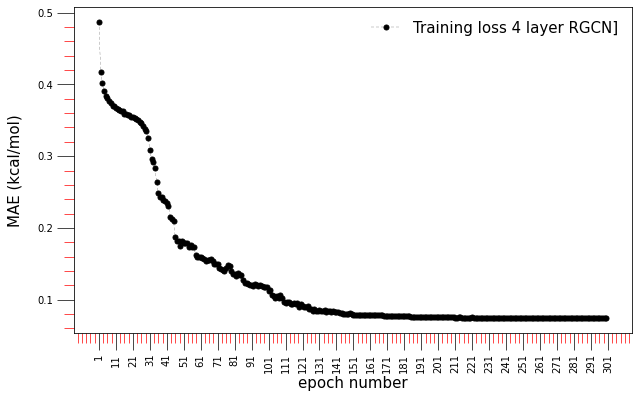

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, 299+2, 1 )
x_points_ = np.arange(1, 299+3, 10 )
ax.set_xticks(x_points_)
plt.xticks(rotation=90)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('MAE (kcal/mol)',fontsize=15, labelpad=15)
ax.plot(x_points, np.array(loss_epoch_trn_list) * tr_std * 23.06 , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
# 23.06 1ev = 23.06 kcal/mol
ax.legend(['Training loss 4 layer RGCN]'], loc='best', fontsize=15, frameon=False)
plt.savefig("4Layer_training_RGCN.png")
plt.show()

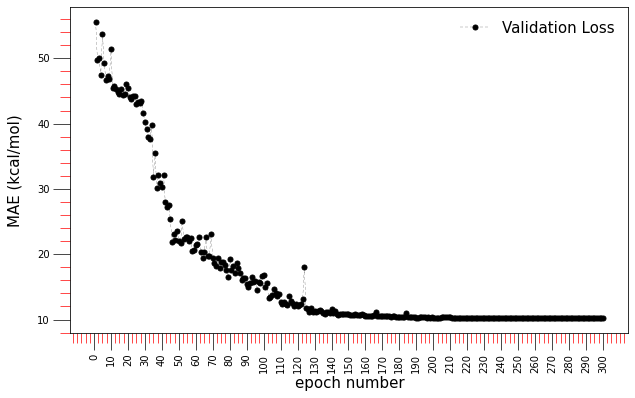

In [ ]:
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, 299+2, 1 )
x_points_ = np.arange(0, 299+3, 10 )
ax.set_xticks(x_points_)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.xticks(rotation=90)
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('MAE (kcal/mol)',fontsize=15, labelpad=15)
ax.plot(x_points, np.array(MAE_epoch_val_list) * 23.06 , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
#ax.plot(x_points, loss_epoch_val_list , color = 'black', marker='v', markersize=5 , linestyle='solid', linewidth=0.2) 
ax.legend(['Validation Loss'], loc='best', fontsize=15, frameon=False)
plt.savefig("MAE_4Layer_RGCN_validation.png")
plt.show()

# min 64 Drop 1.9450273399353026
# min 16 Drop 2.135177117538452
# min 16 no drop 2.1192333839416504

# Evaluation

In [ ]:
#validation error
min(MAE_epoch_val_list) * 23.06 

10.165078851585388

In [ ]:
#load model and continue training
PATH = './best_128_3RGCN_test.pth'
our_saved_model = torch.load(PATH)

In [ ]:
error = 0
actual_values = []
predicted_values = []
our_saved_model.eval()
with torch.no_grad():
    for dtest in test_loader:
        dtest = dtest.to(device)
        edge_type_lengths = dtest.edge_index.shape[1]
        edge_types = torch.Tensor(flat_test_edge_types[:edge_type_lengths]).int()
        pred = model(dtest.x, dtest.edge_index, edge_types, dtest.batch)
        predicted_values.append(pred)
        actual_values. append(dtest.y[:,target])
        error += (pred - dtest.y[:,target]).abs().sum().item()  # MAE
mae_test_set = error / len(test_loader.dataset)
print(f"MAE Test Set: {mae_test_set:>7f}")

MAE Test Set: 70.817450


In [ ]:
m = []
for each in actual_values:
    each = m.append(each.tolist())
actual_ = np.array([item for sublist in m for item in sublist])  * 23.06

n = []
for each in predicted_values:
    each = n.append(each.tolist())
pred_ = np.array([item for sublist in n for item in sublist]) * 23.06

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(actual_, pred_))

In [ ]:
rmse

4.155973164951295

In [ ]:
# utility Functions
def plot_pred_actual(y_true, y_predict,r2, mae, test_num_atoms, rmse):
    """ Plots Predicted energy vs actual energy for input data
    
    Parameters
    ----------
    y_true: 1-d ndarray
            Actual energy
    y_predict: 1-d ndarray
               prediction energy
    r2: float
        r2_score value
    mae : float
          MAE value
    """
    
    x_min = np.min(np.concatenate((y_true , y_predict)))
    x_max = np.max(np.concatenate((y_true, y_predict)))
    line = np.linspace(x_min, x_max, 10)
    plt.plot(line, line,  c='r')

    ax = plt.subplot(1,1,1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])
    im = ax.scatter(y_predict , y_true , marker='.', c=test_num_atoms)
    plt.xlabel('Actual energy (kcal/mol)')
    plt.ylabel('Predicted energy (kcal/mol)')
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('# of atoms in a molecule', rotation=90)
    plt.title(f'4-Layer RGCN \nr2_score :{r2:5.3f}, MAE: {mae:5.3f}, RMSE:{rmse:5.3f}')
    plt.savefig('RGCN_300_4layer_epoch_pred_vs_actual.png')
    plt.show()

In [ ]:
num_atoms = []
for i in range(len(dataset)):
    num_atoms.append(dataset[i].pos.shape[0])
num_atoms = np.array(num_atoms)
train_num_atoms = num_atoms[indices[20000:]]
val_num_atoms = num_atoms[indices[10000:20000]]
test_num_atoms = num_atoms[indices[0:10000]]

Project_RGCN-128-testing.ipynb:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


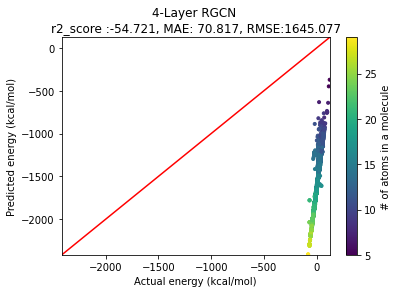

In [ ]:
r2 = r2_score(actual_, pred_)
plot_pred_actual(actual_, pred_, r2, mae_test_set, test_num_atoms, rmse)

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')